In [1]:
import os, sys, logging, configparser
# sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")
#os.environ['CUDA_VISIBLE_DEVICES']='1'

import torch
from tensorboardX import SummaryWriter
from XAE.logging_daily import logging_daily

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

In [3]:
from model.sswae_gan import SSWAE_GAN_MNIST

cfg = configparser.ConfigParser()
cfg.read('./config/train_config_sswae_gan1.cfg')

['./config/train_config_sswae_gan1.cfg']

In [4]:
model = SSWAE_GAN_MNIST(cfg, log, device = device)
model.load(cfg['path_info']['save_path'])

[default |INFO|_base_model.py:25] ------------------------------------------------------------
[default |INFO|_base_model.py:27] model_name : SSWAE_GAN_MNIST
[default |INFO|_base_model.py:27] train_data : rmMNIST
[default |INFO|_base_model.py:27] train_data_label : True
[default |INFO|_base_model.py:27] z_sampler : gaus
[default |INFO|_base_model.py:27] z_dim : 6
[default |INFO|_base_model.py:27] yz_dim : 2
[default |INFO|_base_model.py:27] y_sampler : multinomial
[default |INFO|_base_model.py:27] y_dim : 8
[default |INFO|_base_model.py:27] labeled_class : 0, 1, 3, 4, 5, 6, 9
[default |INFO|_base_model.py:27] unlabeled_class : 7, 8
[default |INFO|_base_model.py:27] test_class : 2
[default |INFO|_base_model.py:27] classification_weight : 
[default |INFO|_base_model.py:27] encoder_pretrain : False
[default |INFO|_base_model.py:27] lr : 5e-4
[default |INFO|_base_model.py:27] beta1 : 0.5
[default |INFO|_base_model.py:27] lr_adv : 2e-4
[default |INFO|_base_model.py:27] beta1_adv : 0.5
[defa

In [5]:
from XAE.dataset import rmMNIST

batch_size = 100
test_data2 = rmMNIST(cfg['path_info']['data_home2'], train = False, label = True, aux=[[2],[]])
test_generator2 = torch.utils.data.DataLoader(test_data2, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)

In [6]:
def result(model, test_generator, unk):
    cls, miscls, pred = torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device)
    for data, condition in test_generator:
        x = data.to(device)
        y = condition.to(device)
        fake_latent = model.encode_s(x)
        recon = model.decode(fake_latent)
        recon_y = model.decode_c(fake_latent)
        predicted = torch.max(recon_y, 1)[1]
        ind = predicted == unk
        pack = torch.cat((x, recon), 1)
        cls = torch.cat((cls, pack[ind,:,:,:]), 0)
        miscls = torch.cat((miscls, pack[~ind,:,:,:]), 0)
        pred = torch.cat((pred, predicted[~ind]), 0)
    cls = cls.to('cpu').detach().numpy()
    miscls = miscls.to('cpu').detach().numpy()
    pred = pred.to('cpu').detach().numpy()
    return cls, miscls, pred

In [7]:
import random

def cls_plot(cls, n=15, rand=True):
    if rand:
        rng = random.sample(range(cls.shape[0]), n)
    else:
        rng = list(range(n))
    original = np.concatenate([cls[i,0,:,:] for i in rng], axis = 1)
    fake = np.concatenate([cls[i,1,:,:] for i in rng], axis = 1)
    plt.figure(figsize = (15,10))
    plt.imshow(np.concatenate((original, fake), axis = 0) , vmin=-1, vmax=1, cmap='gray')
    plt.axis('off')
    plt.title('pred : unk')
    plt.show()

In [8]:
def miscls_plot(miscls, pred, aux=None, n = 15, rand=True):
    space = [[1]*28*n]
    if aux == None:
        max_aux = int(max(pred))
        aux = list(range(max_aux + 1))
    plt.figure(figsize = (15, 3*len(aux)))
    cnt = 0
    for i in aux:
        cnt += 1
        plt.subplot(len(aux), 1, cnt)
        
        ind = pred == aux.index(i)
        
        if rand:
            rng = random.sample(range(sum(ind)), n)
        else:
            rng = range(n)
            
        original = np.concatenate([miscls[ind][j,0,:,:] for j in rng], axis=1)
        fake = np.concatenate([miscls[ind][j,1,:,:] for j in rng], axis=1)
        plt.imshow(np.concatenate((original, space ,fake), axis = 0) , vmin=-1, vmax=1, cmap='gray')
        plt.title(f'pred : {int(i)}')
        plt.axis('off')
    plt.show()

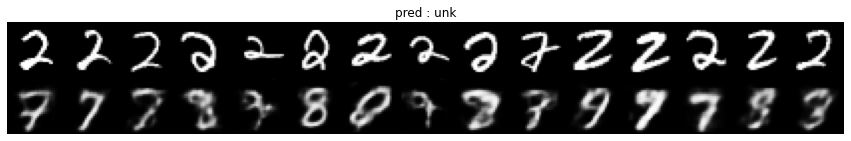

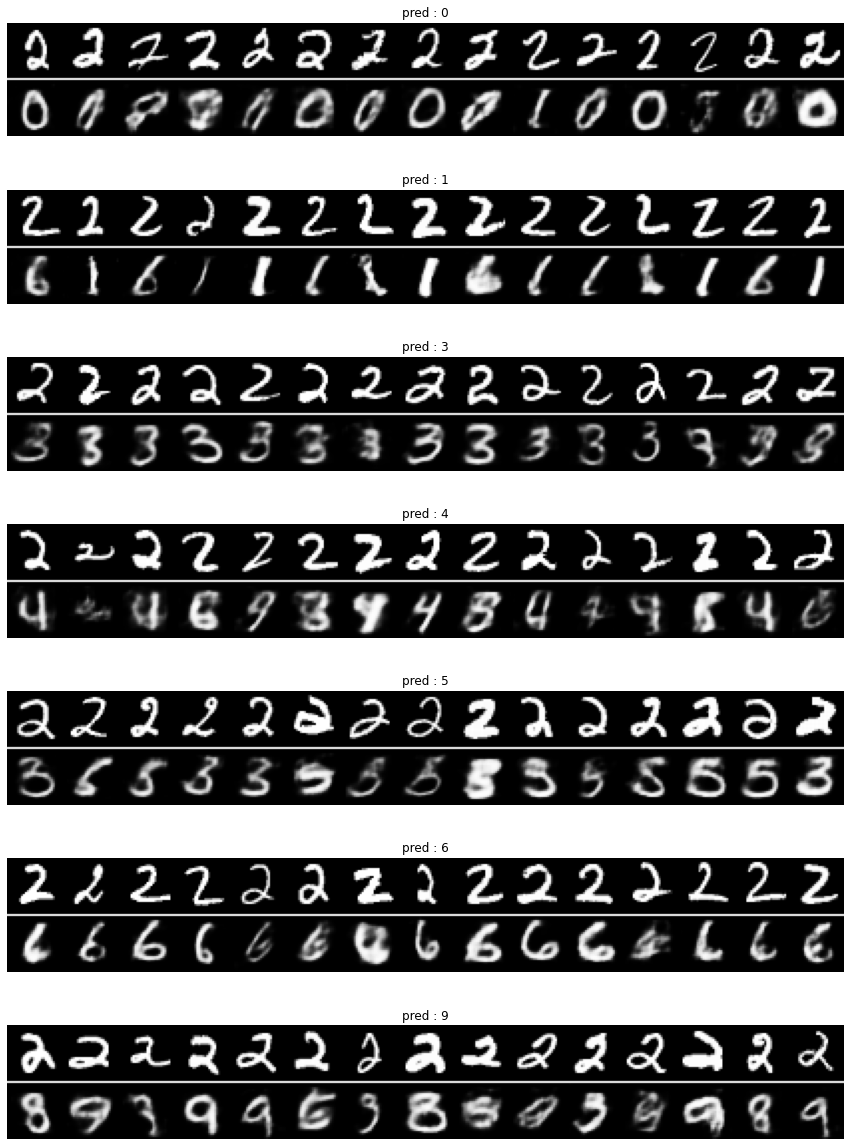

In [10]:
cls, miscls, pred = result(model, test_generator2, 7)
cls_plot(cls)
miscls_plot(miscls, pred, aux=[0,1,3,4,5,6,9])

[default |INFO|_base_model.py:25] ------------------------------------------------------------
[default |INFO|_base_model.py:27] model_name : SSWAE_GAN_MNIST
[default |INFO|_base_model.py:27] train_data : rmMNIST
[default |INFO|_base_model.py:27] train_data_label : True
[default |INFO|_base_model.py:27] z_sampler : gaus
[default |INFO|_base_model.py:27] z_dim : 6
[default |INFO|_base_model.py:27] yz_dim : 2
[default |INFO|_base_model.py:27] y_sampler : multinomial
[default |INFO|_base_model.py:27] y_dim : 3
[default |INFO|_base_model.py:27] labeled_class : 7, 8
[default |INFO|_base_model.py:27] unlabeled_class : 0, 1, 3, 4, 5, 6, 9
[default |INFO|_base_model.py:27] test_class : 2
[default |INFO|_base_model.py:27] classification_weight : 
[default |INFO|_base_model.py:27] encoder_pretrain : False
[default |INFO|_base_model.py:27] lr : 5e-4
[default |INFO|_base_model.py:27] beta1 : 0.5
[default |INFO|_base_model.py:27] lr_adv : 2e-4
[default |INFO|_base_model.py:27] beta1_adv : 0.5
[defa

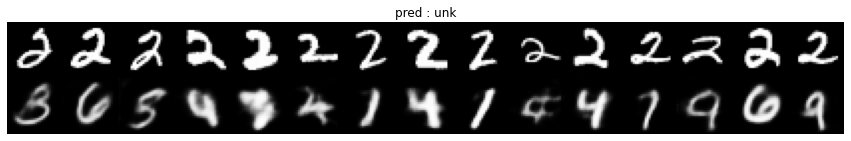

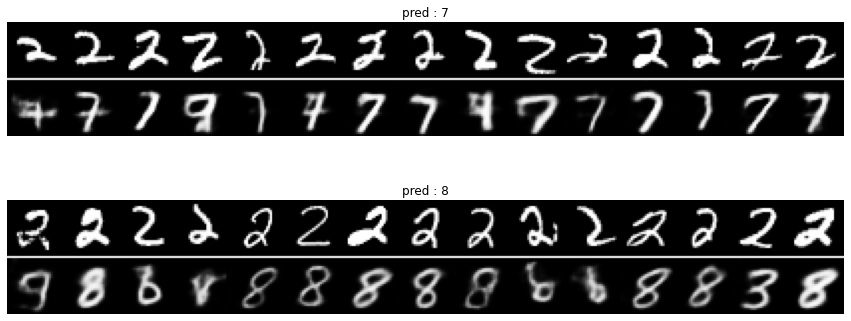

In [11]:
cfg = configparser.ConfigParser()
cfg.read('./config/train_config_sswae_gan2.cfg')
model = SSWAE_GAN_MNIST(cfg, log, device = device)
model.load(cfg['path_info']['save_path'])
cls, miscls, pred = result(model, test_generator2, 2)
cls_plot(cls)
miscls_plot(miscls, pred, aux=[7,8])

[default |INFO|_base_model.py:25] ------------------------------------------------------------
[default |INFO|_base_model.py:27] model_name : SSWAE_GAN_MNIST
[default |INFO|_base_model.py:27] train_data : rmMNIST
[default |INFO|_base_model.py:27] train_data_label : True
[default |INFO|_base_model.py:27] z_sampler : gaus
[default |INFO|_base_model.py:27] z_dim : 6
[default |INFO|_base_model.py:27] yz_dim : 2
[default |INFO|_base_model.py:27] y_sampler : multinomial
[default |INFO|_base_model.py:27] y_dim : 3
[default |INFO|_base_model.py:27] labeled_class : 7, 8
[default |INFO|_base_model.py:27] unlabeled_class : 0, 1, 3, 4, 5, 6, 9
[default |INFO|_base_model.py:27] test_class : 2
[default |INFO|_base_model.py:27] classification_weight : 
[default |INFO|_base_model.py:27] encoder_pretrain : False
[default |INFO|_base_model.py:27] lr : 5e-4
[default |INFO|_base_model.py:27] beta1 : 0.5
[default |INFO|_base_model.py:27] lr_adv : 2e-4
[default |INFO|_base_model.py:27] beta1_adv : 0.5
[defa

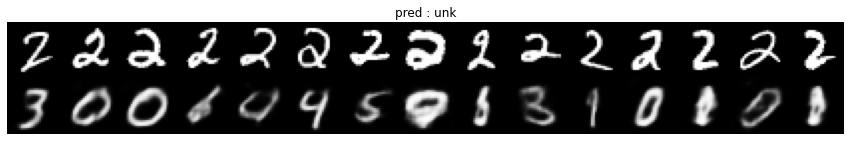

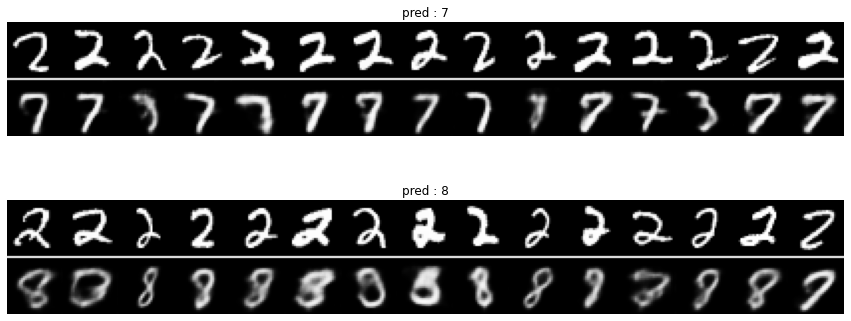

In [12]:
cfg = configparser.ConfigParser()
cfg.read('./config/train_config_sswae_gan2-1.cfg')
model = SSWAE_GAN_MNIST(cfg, log, device = device)
model.load(cfg['path_info']['save_path'])
cls, miscls, pred = result(model, test_generator2, 2)
cls_plot(cls)
miscls_plot(miscls, pred, aux=[7,8])